# Jupiter Notebook to build a quick and imperfect prediction solution

This notebook is an attempt to train a model to predict the salary in Data Science based on the kaggle dataset from https://www.kaggle.com/datasets/lainguyn123/data-science-salary-landscape.

In [26]:
%pip install scikit-learn
%pip install numpy
%pip install pandas 
%pip install seaborn
%pip install tensorflow
%pip install xgboost
%pip install pygad
%pip install scikeras


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [27]:
# Package for linear regressions


import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn import datasets, linear_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score,root_mean_squared_log_error
from sklearn.model_selection import train_test_split

## Loading and Cleaning datasets

In this section, we will load the dataset and extract the features and performs the cleaning.

In [62]:
salaries_dataset_url = './ds_salaries.csv'
full_dataset = pd.read_csv(salaries_dataset_url)

# Reorder the salary column and remove the salary and currency columns and ID
cols = full_dataset.columns.tolist()
cols =  cols[1:4] + cols[8:] + [cols[6]]
print("New column order", cols)

# Split X and Y
feature_cols = cols[0:-1]
print("Features num=", len(feature_cols), feature_cols)

X = full_dataset.loc[:, feature_cols]
# We apply log on the salary feature
Y =  np.log(full_dataset.loc[:, ["salary_in_usd"] ])

X.info()
Y.info()

New column order ['work_year', 'experience_level', 'employment_type', 'employee_residence', 'remote_ratio', 'company_location', 'company_size', 'salary_currency']
Features num= 7 ['work_year', 'experience_level', 'employment_type', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   employee_residence  607 non-null    object
 4   remote_ratio        607 non-null    int64 
 5   company_location    607 non-null    object
 6   company_size        607 non-null    object
dtypes: int64(2), object(5)
memory usage: 33.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 1 columns):
 # 

### Split the dataset in train and test



In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [30]:
# List empty columns (normally none)
print("Empty columns in training set", X_train.columns[X_train.isnull().any()])

Empty columns in training set Index([], dtype='object')


### Generate dummies

In [31]:
# Generate dummies

# Convert features with categories into numbers
featureWithStrings = X_train.select_dtypes(include=['object']).columns

def generate_dummies(df: pd.DataFrame, colName: str):
    one_hot = pd.get_dummies(prefix=colName, prefix_sep="_",data=df[colName])
    data_df = df.drop(colName,axis = 1)
    return data_df.join(one_hot)



In [32]:
def create_dummies_dataset(dataset):
    X_train_dummies = generate_dummies(dataset, colName="employment_type")
    X_train_dummies = generate_dummies(X_train_dummies, colName="experience_level")
    #X_train_dummies = generate_dummies(X_train_dummies, colName="employee_residence")
    #X_train_dummies = generate_dummies(X_train_dummies, colName="company_location")
    X_train_dummies = generate_dummies(X_train_dummies, colName="company_size")
    print(X_train_dummies.keys())
    return X_train_dummies

X_train_d = create_dummies_dataset(X_train)
X_test_d = create_dummies_dataset(X_test)



Index(['work_year', 'employee_residence', 'remote_ratio', 'company_location',
       'employment_type_CT', 'employment_type_FL', 'employment_type_FT',
       'employment_type_PT', 'experience_level_EN', 'experience_level_EX',
       'experience_level_MI', 'experience_level_SE', 'company_size_L',
       'company_size_M', 'company_size_S'],
      dtype='object')
Index(['work_year', 'employee_residence', 'remote_ratio', 'company_location',
       'employment_type_CT', 'employment_type_FL', 'employment_type_FT',
       'employment_type_PT', 'experience_level_EN', 'experience_level_EX',
       'experience_level_MI', 'experience_level_SE', 'company_size_L',
       'company_size_M', 'company_size_S'],
      dtype='object')


### Label Encoding

We will encode few feature columns.

In [33]:
featureWithStrings = ['employee_residence', 'company_location', 'remote_ratio']

def encode_labels(df_train, df_test, features):
    for col in features:
        try:
            enc = LabelEncoder()
            mcol = pd.concat([df_train[col], df_test[col]])
            enc.fit(mcol)
            df_train[col] = enc.transform(df_train[col])
            df_test[col] = enc.transform(df_test[col])
        except Exception as error:
            print("Exception with the column " + col)

encode_labels(X_train_d, X_test_d,featureWithStrings)



In [34]:
print(X_train_d.head())


     work_year  employee_residence  remote_ratio  company_location  \
124       2021                  18             1                16   
434       2022                  20             2                18   
472       2022                  55             2                48   
185       2021                  29             2                27   
228       2021                  55             0                48   

     employment_type_CT  employment_type_FL  employment_type_FT  \
124               False               False               False   
434               False               False                True   
472               False               False                True   
185               False               False                True   
228               False               False                True   

     employment_type_PT  experience_level_EN  experience_level_EX  \
124                True                 True                False   
434               False               

### Check correlations with variables

We will output some graphs to check the correlations between the features and the price



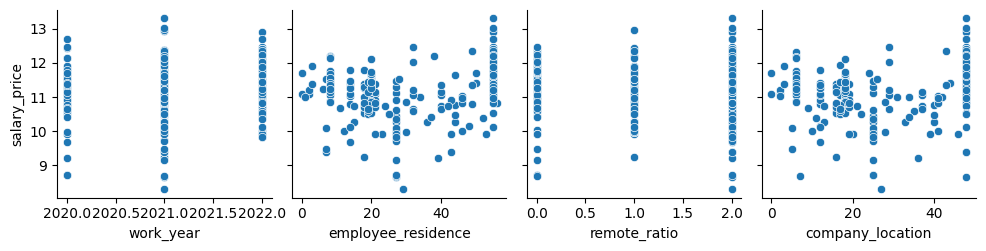

In [48]:
numeric_features = X_train_d.select_dtypes(include=['int64']).columns

visu_df = X_train_d.copy()
visu_df["salary_price"] = y_train
sns.pairplot(data=visu_df, y_vars=['salary_price'], x_vars=numeric_features[:5])


### Export the normalized dataset

In [49]:
## Export cleant data
def export(X,y, csvName):
    df = X.copy()
    df['salary_in_usd'] = y.loc[:, ["salary_in_usd"] ];
    df.to_csv(csvName, index=False)  



export(X_train_d, y_train, "train.csv")
export(X_test_d, y_test, "test.csv")

## Model training

We will use a hierarchical model to train.

In [52]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Lasso, LassoCV, RidgeCV, ElasticNet
#from xgboost import XGBRegressor

from sklearn.svm import SVR


def fit_model(retainedColumns: list, X, y):
    cat_selector = make_column_selector(dtype_include=object)
    num_selector = make_column_selector(dtype_include=np.number)
    cat_selector(X)


    cat_tree_processor = OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1,
        encoded_missing_value=-2,
    )
    num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

    cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
    num_linear_processor = make_pipeline(
        StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
    )

    linear_preprocessor = make_column_transformer(
        (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
    )


    tree_preprocessor = make_column_transformer(
        (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
    )
    lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
    

    rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
    
    gbdt_pipeline = make_pipeline(
        tree_preprocessor, HistGradientBoostingRegressor(random_state=0)
    )
    
    knn_pipeline = make_pipeline(
        linear_preprocessor, KNeighborsRegressor()
    )

    estimators = [
        ("Random Forest", rf_pipeline),
        ("LassoCV", lasso_pipeline),
        ("Gradient Boosting", gbdt_pipeline),
        ("KNN", knn_pipeline),   
        #("DecisionTreeRegressor", make_pipeline(tree_preprocessor, DecisionTreeRegressor())),
        #("LR", make_pipeline(linear_preprocessor, LinearRegression())),   
        #("XGB", make_pipeline(linear_preprocessor, XGBRegressor())),   
        #("LGBM", make_pipeline(linear_preprocessor, LGBMRegressor())),   
        ("SVR", make_pipeline(linear_preprocessor, SVR())),   
        #('Ridge', make_pipeline(linear_preprocessor, Ridge(alpha=10))),
        ('Lasso', make_pipeline(linear_preprocessor, Lasso(alpha=0.003487))),
        ('ENet', make_pipeline(linear_preprocessor, ElasticNet(alpha=0.006974)))
    ]
    train_normalized_retained_X = X[retainedColumns]
    stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
    stacking_regressor.fit(train_normalized_retained_X, y)
    return stacking_regressor



### Graph and precision evaluation

In [67]:
retained_columns = X_train_d.columns   
print("We use ", len(retained_columns), " the columns are ", retained_columns)
regr = fit_model(retained_columns,  X_train_d, y_train )




We use  15  the columns are  Index(['work_year', 'employee_residence', 'remote_ratio', 'company_location',
       'employment_type_CT', 'employment_type_FL', 'employment_type_FT',
       'employment_type_PT', 'experience_level_EN', 'experience_level_EX',
       'experience_level_MI', 'experience_level_SE', 'company_size_L',
       'company_size_M', 'company_size_S'],
      dtype='object')


/home/sleroy/git/amplify-elb-blog/backend/venv/lib/python3.12/site-packages/sklearn/ensemble/_stacking.py:970: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [71]:
print("X_train", X_train_d.shape)
print("X_test", X_test_d.shape)
print("Y_train", y_train.shape)
print("Y_test", y_test.shape)

X_train (406, 15)
X_test (201, 15)
Y_train (406, 1)
Y_test (201, 1)


In [73]:

## Predict the value for the test dataset
y_pred = regr.predict(X_test_d)


### Compute accuracy

In [ ]:

# The coefficients
#print("Coefficients: \n", regr.coef_)
# The mean squared error
print("root_mean_squared_log_error: %.2f" % root_mean_squared_log_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination, R2: %.2f" % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_train_d.index, y_pred, color="black")
plt.scatter(X_train_d.index, y_test, color="blue")
#plt.scatter(train["Id"], y_test, color="blue")
#plt.plot(test_features_X_df,  test_predicted_Y_df, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())
plt.tick_params(axis='both', labelsize=12, width=2, length=5)  # Style

plt.xlabel('ID')
plt.ylabel('Predicted price')
plt.title('Accuracy')
plt.show()


sns.set_theme(style="darkgrid")

data = X_train_d.copy()
data["Prediction" ] = y_pred
data["Expected" ] = y_test
data["id"] = data.index
g = sns.jointplot(x="Expected", y="Prediction", data=data,
                  kind="reg", truncate=False,
                  color="m", height=7)